In [2]:
%matplotlib inline
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("../input/santander-customer-transaction-prediction/train.csv")
test = pd.read_csv("../input/santander-customer-transaction-prediction/test.csv")

# 関数

In [4]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show()
    
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()
    
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(16,9))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

# shape

In [5]:
train.shape

(200000, 202)

In [6]:
test.shape

(200000, 201)

# dataの頭

In [7]:
train.head(3)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965


In [8]:
test.head(3)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794


# 概略データ

In [9]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [10]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


# missing value

In [11]:
train.isnull().sum().head(5) # 変数ごとに見て欠損値がない

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
dtype: int64

In [12]:
train.isnull().sum().sum() #トレーニングデータ全体で欠損値なし

0

In [13]:
test.isnull().sum().sum()  #テストデータでも欠損値なし

0

# column name

In [14]:
train.columns.values

array(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11',
       'var_12', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17',
       'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23',
       'var_24', 'var_25', 'var_26', 'var_27', 'var_28', 'var_29',
       'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35',
       'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41',
       'var_42', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47',
       'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53',
       'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59',
       'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65',
       'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71',
       'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77',
       'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83',
       'var_84', 'var_85', 'var_86', 'var_87', 'var

# 分布(最初16個の属性について学習データとテストデータ間での散布図)

<Figure size 432x288 with 0 Axes>

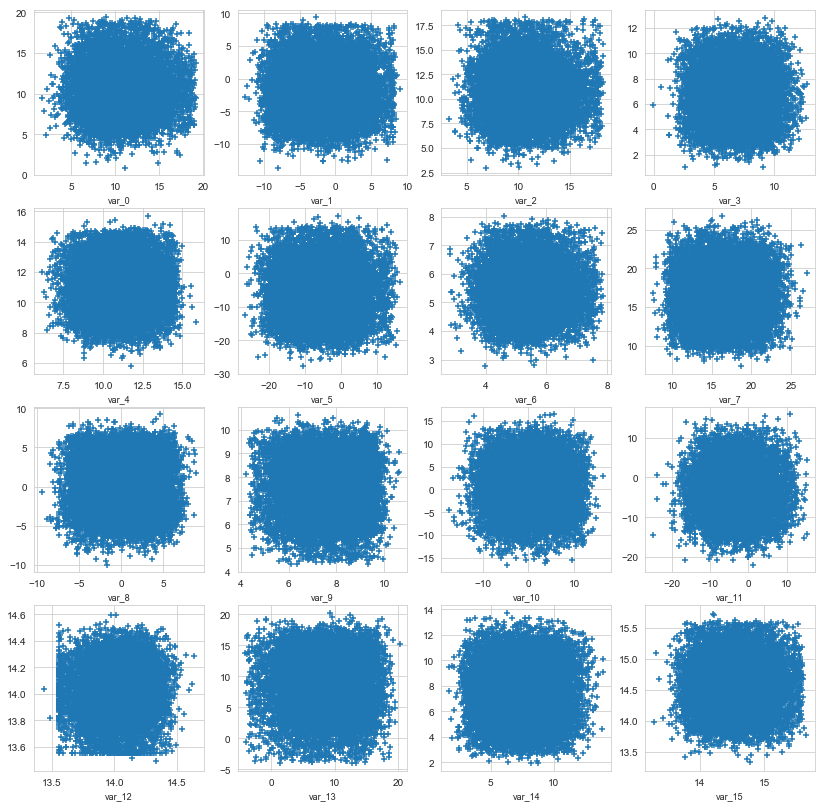

In [15]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(X_train[::20],X_test[::20], features)
# 考察：var12では左側13.7あたりでテストデータが様々な値を取っており、外れ値が存在することもわかる
# var15でも外れ値を観測することができる

## 行ごとに平均値と標準偏差の分布を確認(ユーザーごとの特性を把握)

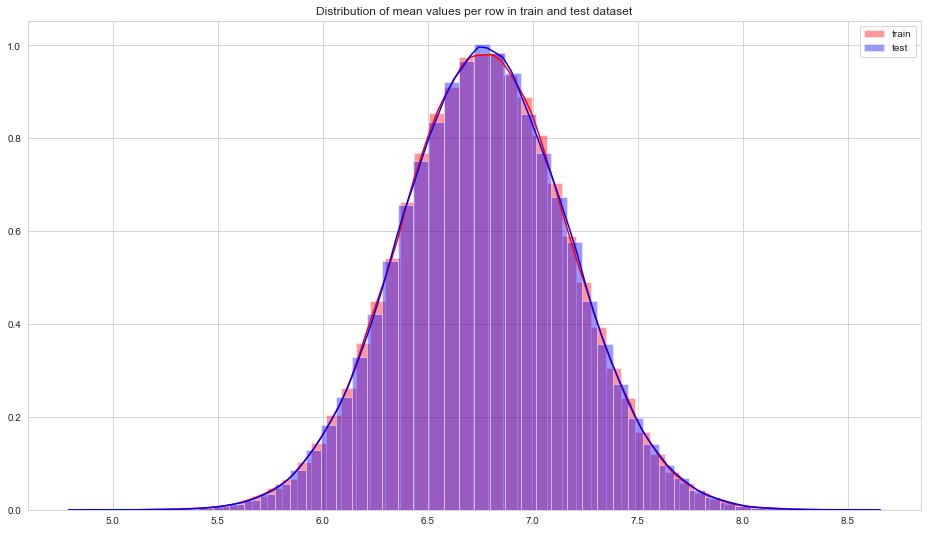

In [16]:
## Distribution of mean values per row in train and test dataset 
plt.figure(figsize=(16,9))
plt.title("Distribution of mean values per row in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].mean(axis=1), color='r', label='train')
sns.distplot(test[features].mean(axis=1), color='b', label='test')
plt.legend(loc="upper right")
# 考察: train, testのどちらでもユーザーごとの全属性平均値は正規分布が観測され、train, testによるユーザーの差はない

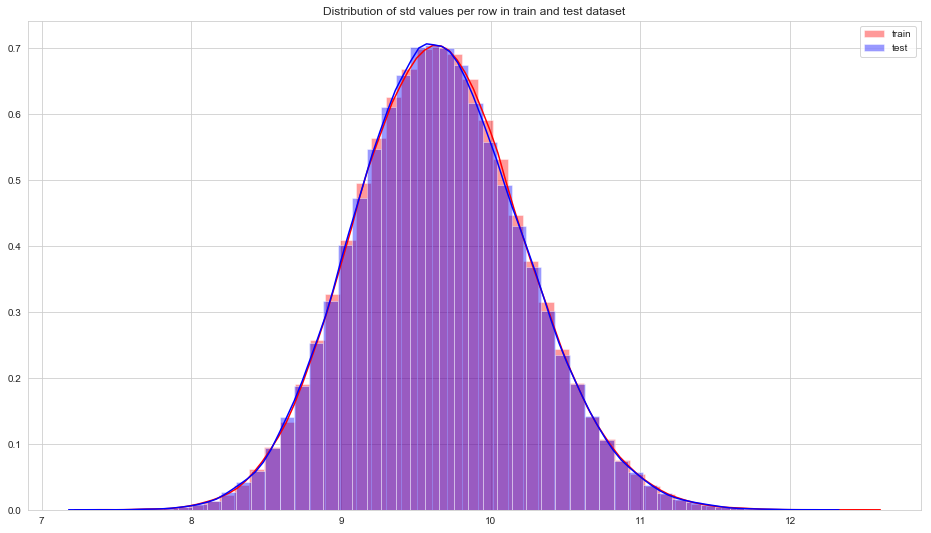

In [17]:
plt.figure(figsize=(16,9)) 
plt.title("Distribution of std values per row in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].std(axis=1), color='r', label='train')
sns.distplot(test[features].std(axis=1), color='b', label='test')
plt.legend(loc="upper right")
#考察: 標準偏差でもユーザーごとに見るとtrainとtestで大きな違いはない

## 列ごとに平均値と標準偏差を確認(属性ごとの特徴を確認)

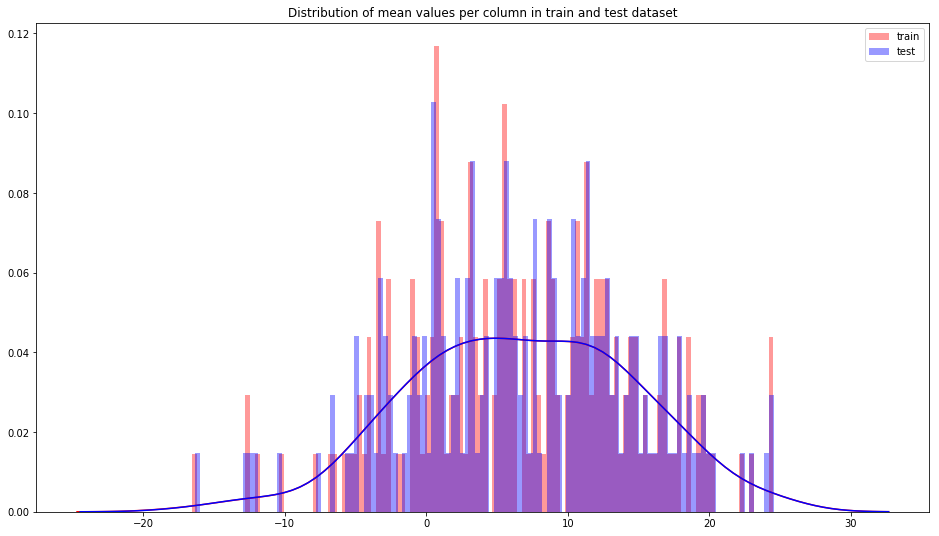

In [15]:
plt.figure(figsize=(16,9))
plt.title("Distribution of mean values per column in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].mean(axis=0), color='r', bins=120, label='train')
sns.distplot(test[features].mean(axis=0), color='b', bins=120, label='test')
plt.legend(loc="upper right")
# 考察: ヒストグラムの柱の値に基づくと標準偏差はtrainとtestで差があるように見えるが、確率分布戦に差が見られないため
# 確率的には無視できる差であると考えられる

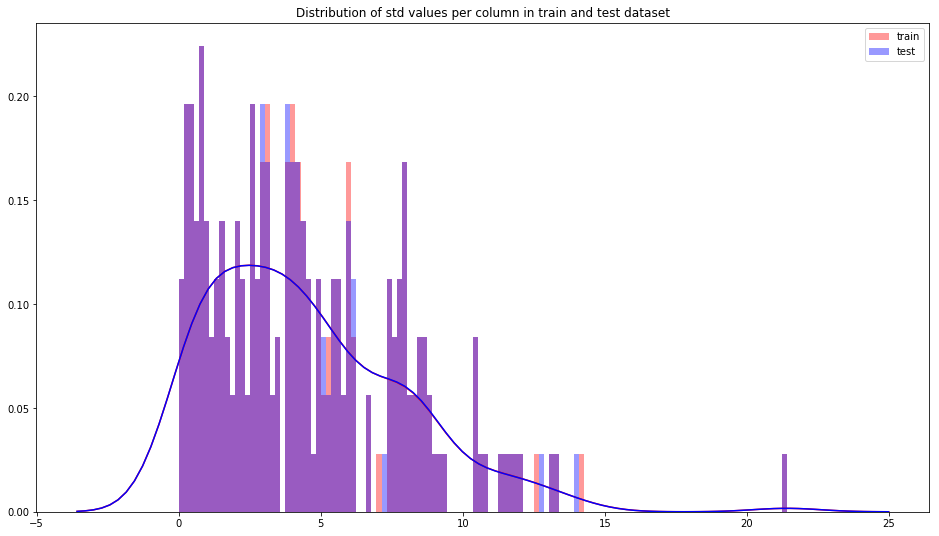

In [16]:
plt.figure(figsize=(16,9))
plt.title("Distribution of std values per column in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].std(axis=0), color='r', bins=120, label='train')
sns.distplot(test[features].std(axis=0), color='b', bins=120, label='test')
plt.legend(loc="upper right")
# 考察:一個上のケース同様。標準偏差ではtrain, test間でのヒストグラムの値の違いが小さくなっている

## トレーニングデータの中での行ごとの平均をtargetで分けて確認(ターゲットで分けた時にユーザーごとの特性に相違があるのか)

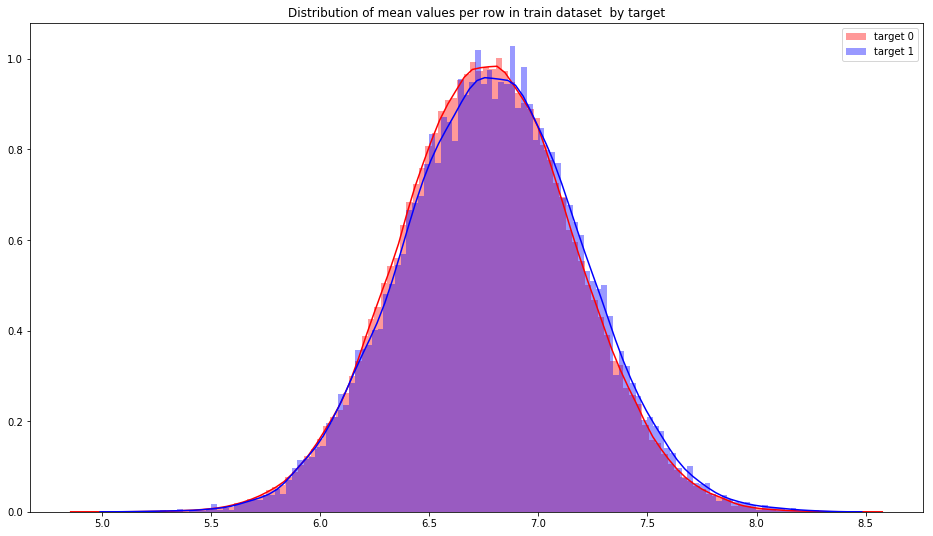

In [17]:
plt.figure(figsize=(16,9))
plt.title("Distribution of mean values per row in train dataset  by target")
features = train.columns.values[2:202]
train_0 = train[train["target"]==0]
train_1 = train[train["target"]==1]
sns.distplot(train_0[features].mean(axis=1), color='r', bins=120, label='target 0')
sns.distplot(train_1[features].mean(axis=1), color='b',bins=120, label='target 1')
plt.legend(loc="upper right")
# 考察：どちらも正規分布であるが、確率的にはtarget1の方がtarget0よりも真ん中の値で高い分布となっている

## トレーニングデータの中での列ごとの平均をtargetで分けて確認

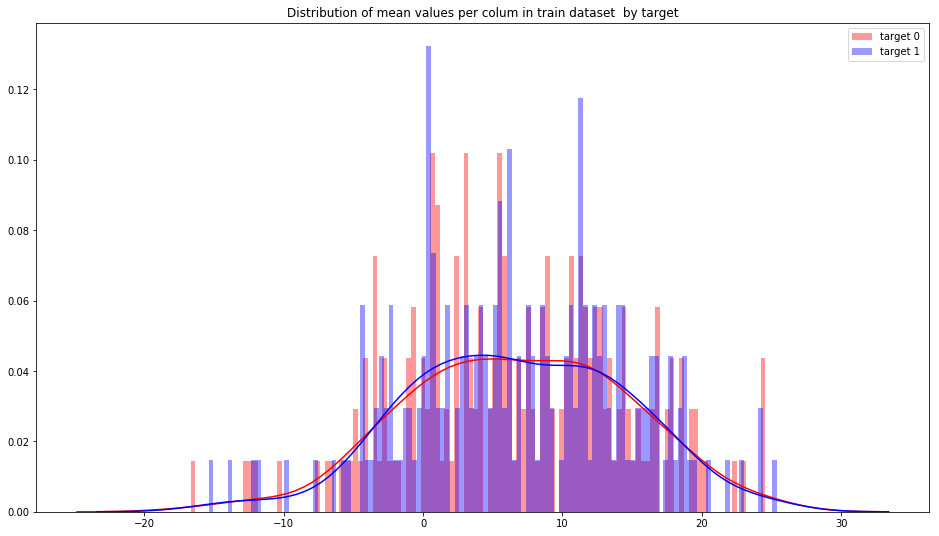

In [18]:
plt.figure(figsize=(16,9))
plt.title("Distribution of mean values per colum in train dataset  by target")
features = train.columns.values[2:202]
train_0 = train[train["target"]==0]
train_1 = train[train["target"]==1]
sns.distplot(train_0[features].mean(axis=0), color='r', bins=120, label='target 0')
sns.distplot(train_1[features].mean(axis=0), color='b',bins=120, label='target 1')
plt.legend(loc="upper right")
# 考察：ヒストグラムの値に差があり、真ん中よりも左側で確率分布の値に差があることがわかる

## 学習とテストデータセットでの行ごとの最小値の分布を確認

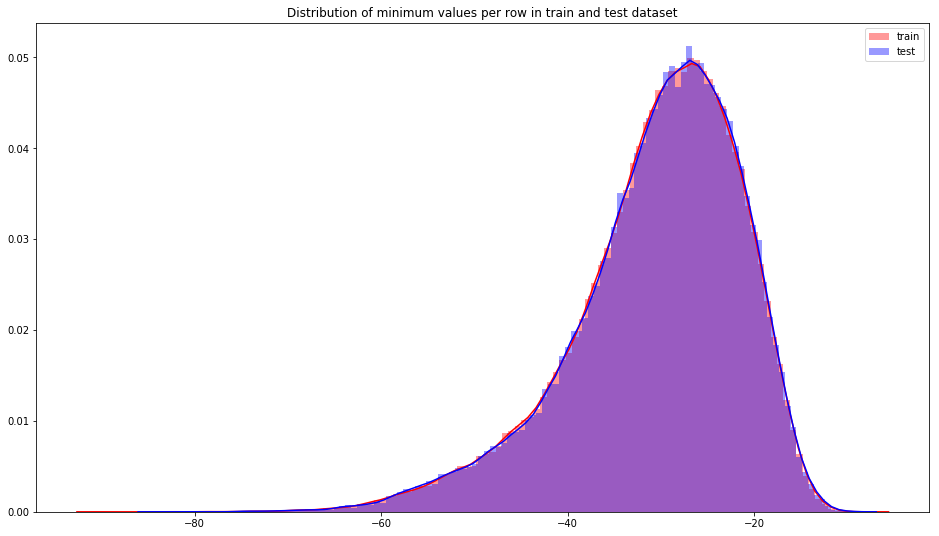

In [19]:
plt.figure(figsize=(16,9))
plt.title("Distribution of minimum values per row in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].min(axis=1), color='r', bins=120, label='train')
sns.distplot(test[features].min(axis=1), color='b',bins=120, label='test')
plt.legend(loc="upper right")
# 考察：ユーザーごとによる最小値のばらつきに差はなく、左に歪んだ分布となっている

## 学習とテストデータセットでの列ごとの最小値の分布を確認

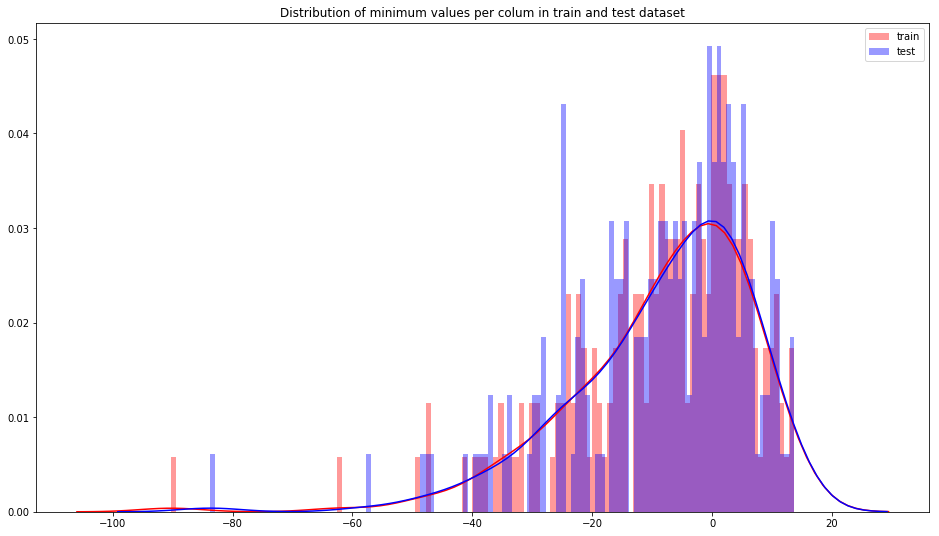

In [20]:
plt.figure(figsize=(16,9))
plt.title("Distribution of minimum values per colum in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].min(axis=0), color='r', bins=120, label='train')
sns.distplot(test[features].min(axis=0), color='b',bins=120, label='test')
plt.legend(loc="upper right")
# 考察: 列ごとで最小値を見ると、ばらつきの分布には差が見られる。確率分布に差はなく、
# 左に歪んだ分布であるという事実は変わらない

## 学習とテストデータセットでの行ごとの最大値の分布を確認

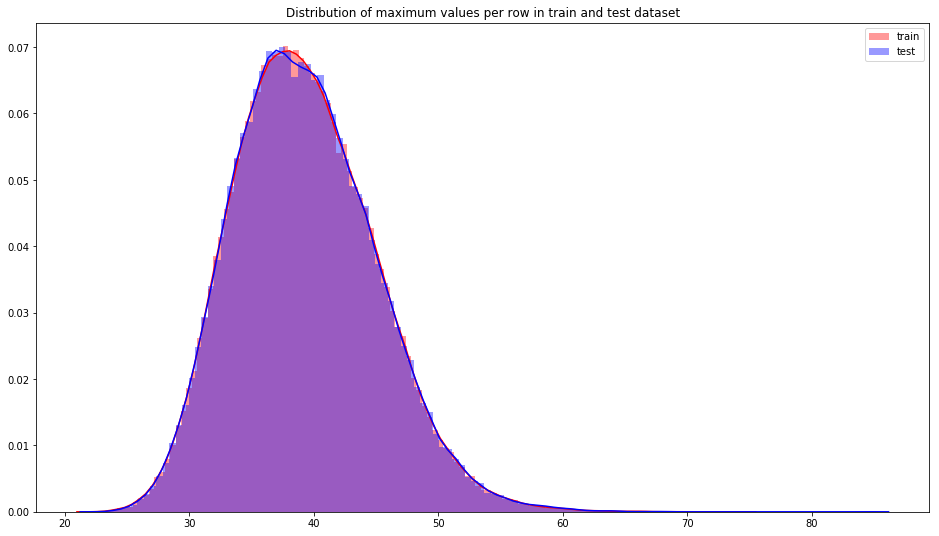

In [21]:
plt.figure(figsize=(16,9))
plt.title("Distribution of maximum values per row in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].max(axis=1), color='r', bins=120, label='train')
sns.distplot(test[features].max(axis=1), color='b',bins=120, label='test')
plt.legend(loc="upper right")
# 考察：最大値の分布にtrain, testによる差はなし

## 学習とテストデータセットでの列ごとの最大値の分布を確認

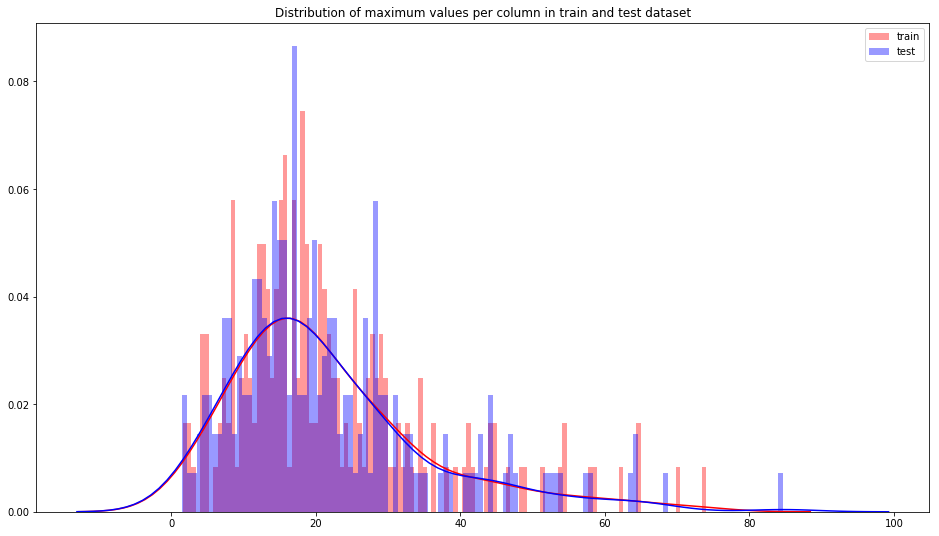

In [22]:
plt.figure(figsize=(16,9))
plt.title("Distribution of maximum values per column in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].max(axis=0), color='r', bins=120, label='train')
sns.distplot(test[features].max(axis=0), color='b',bins=120, label='test')
plt.legend(loc="upper right")
# 考察：ヒストグラムの値に差は見られるが、確率分布に違いが見られないため、分布では大きな差はない

## train dataでtargetごとに分けた時の行ごとの最小値の分布

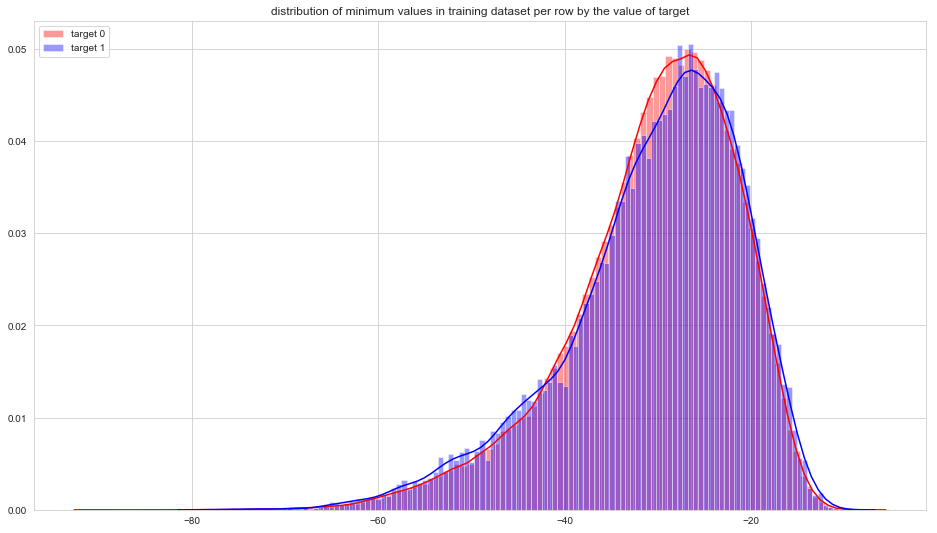

In [50]:
plt.figure(figsize=(16,9))
plt.title("distribution of minimum values in training dataset per row by the value of target")
train_0 = train[train["target"]==0]
train_1 = train[train["target"]==1]
sns.distplot(train_0[features].min(axis=1), color="r", bins=120, label="target 0")
sns.distplot(train_1[features].min(axis=1), color="b", bins=120, label="target 1")
plt.legend(loc="upper left")
# 考察：target1の方が、-30付近での値をとる確率が小さく、-60から-40の値をとる確率が大きくなっているため、最小値
# の違いを組み込む事が有意に作用するのではないかと考える

## train dataでtargetごとに分けた時の行ごとの最大値の分布

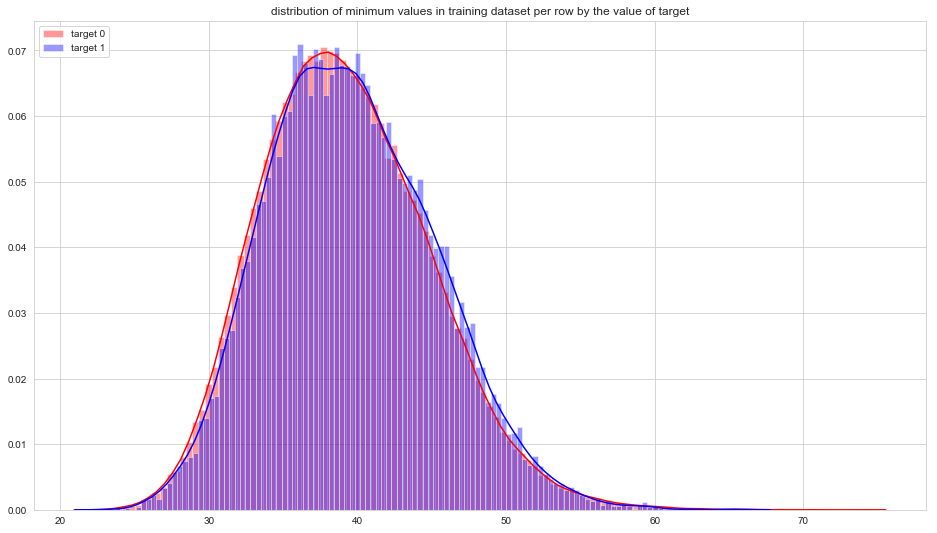

In [51]:
plt.figure(figsize=(16,9))
plt.title("distribution of minimum values in training dataset per row by the value of target")
train_0 = train[train["target"]==0]
train_1 = train[train["target"]==1]
sns.distplot(train_0[features].max(axis=1), color="r", bins=120, label="target 0")
sns.distplot(train_1[features].max(axis=1), color="b", bins=120, label="target 1")
plt.legend(loc="upper left")
# targetごとに見ると確率分布から差があることが読み取れる。真ん中の値より小さくなる確率がtarget1のときの方が高い。

## 学習とテストデータセットでの行ごとの歪度の分布を確認

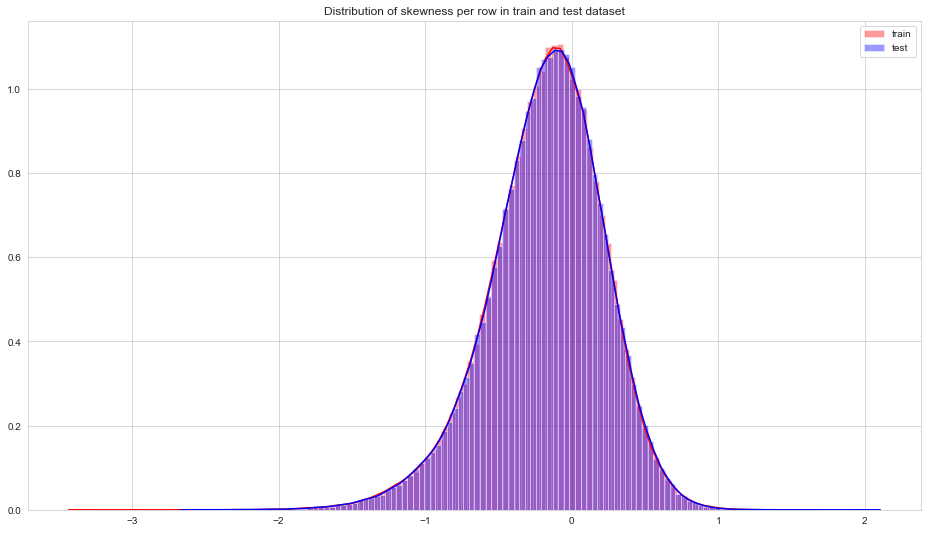

In [41]:
plt.figure(figsize=(16,9))
plt.title("Distribution of skewness per row in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].skew(axis=1), color='r', bins=120, label='train')
sns.distplot(test[features].skew(axis=1), color='b',bins=120, label='test')
plt.legend(loc="upper right")
# train, test間でユーザーごとの歪度による差はない

## 学習とテストデータセットでの列ごとの歪度の分布を確認

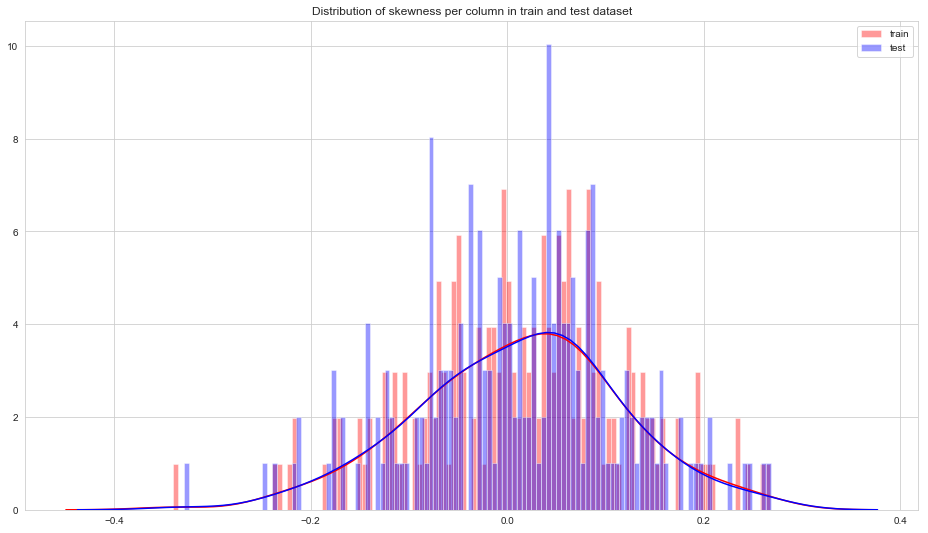

In [43]:
plt.figure(figsize=(16,9))
plt.title("Distribution of skewness per column in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].skew(axis=0), color='r', bins=120, label='train')
sns.distplot(test[features].skew(axis=0), color='b',bins=120, label='test')
plt.legend(loc="upper right")
# 考察：train, testによる差はなし

## 学習とテストデータセットでの行ごとの尖度の分布を確認

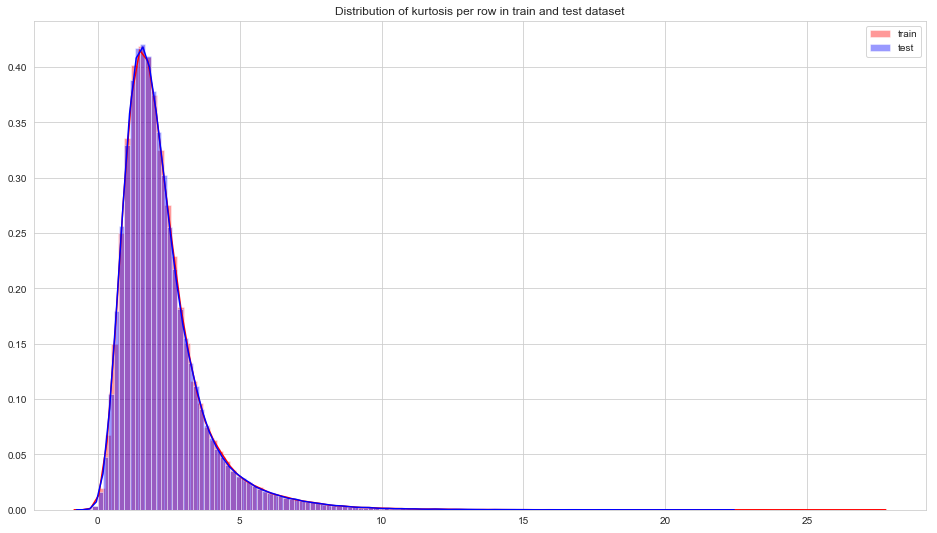

In [44]:
plt.figure(figsize=(16,9))
plt.title("Distribution of kurtosis per row in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].kurtosis(axis=1), color='r', bins=120, label='train')
sns.distplot(test[features].kurtosis(axis=1), color='b',bins=120, label='test')
plt.legend(loc="upper right")
# 考察:train, testによる差はなし

## 学習とテストデータセットでの列ごとの尖度の分布を確認

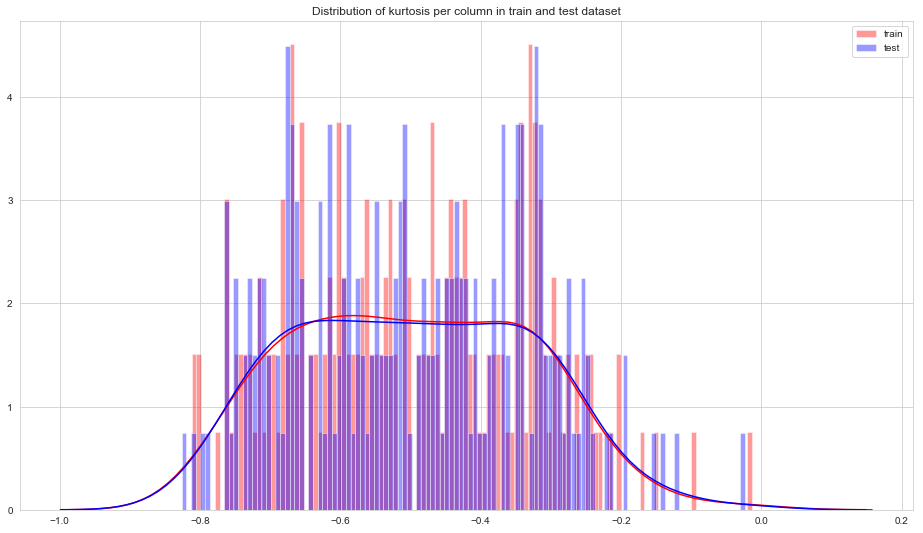

In [45]:
plt.figure(figsize=(16,9))
plt.title("Distribution of kurtosis per column in train and test dataset")
features = train.columns.values[2:202]
sns.distplot(train[features].kurtosis(axis=0), color='r', bins=120, label='train')
sns.distplot(test[features].kurtosis(axis=0), color='b',bins=120, label='test')
plt.legend(loc="upper right")

## 学習データでの行ごとの歪度の分布をtargetで分けて確認

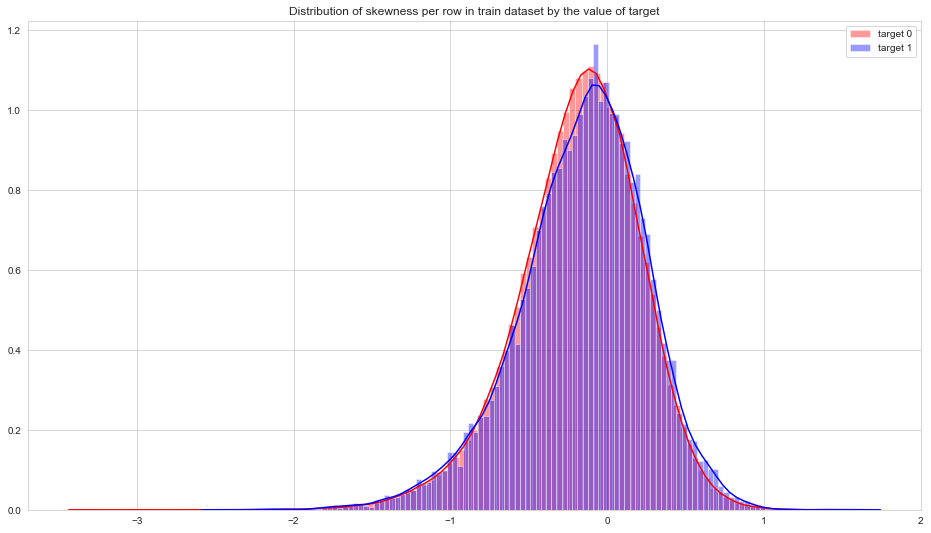

In [46]:
plt.figure(figsize=(16,9))
plt.title("Distribution of skewness per row in train dataset by the value of target")
features = train.columns.values[2:202]
target_0 = train[train["target"]==0]
target_1 = train[train["target"]==1]
sns.distplot(train_0[features].skew(axis=1), color='r', bins=120, label='target 0')
sns.distplot(train_1[features].skew(axis=1), color='b',bins=120, label='target 1')
plt.legend(loc="upper right")
# 考察: target 1の方が両裾での確率が大きくなっており、ユーザーごとで見ると歪みが大きい分布となっている。

## 学習データでの列ごとの歪度の分布をtargetで分けて確認

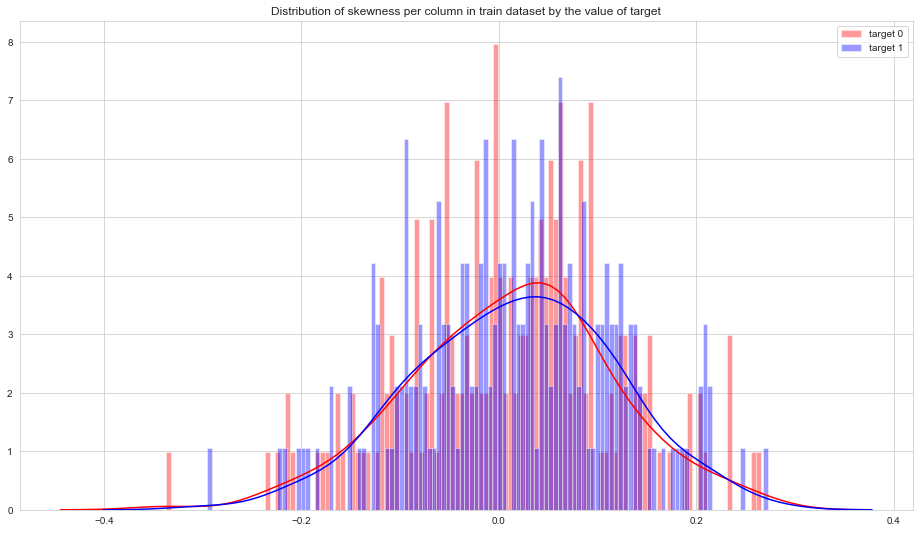

In [47]:
plt.figure(figsize=(16,9))
plt.title("Distribution of skewness per column in train dataset by the value of target")
features = train.columns.values[2:202]
target_0 = train[train["target"]==0]
target_1 = train[train["target"]==1]
sns.distplot(train_0[features].skew(axis=0), color='r', bins=120, label='target 0')
sns.distplot(train_1[features].skew(axis=0), color='b',bins=120, label='target 1')
plt.legend(loc="upper right")
# 考察: 列ごとにみてもtarget1の方が歪みが大きい

## 学習データでの行ごとの尖度の分布をtargetで分けて確認

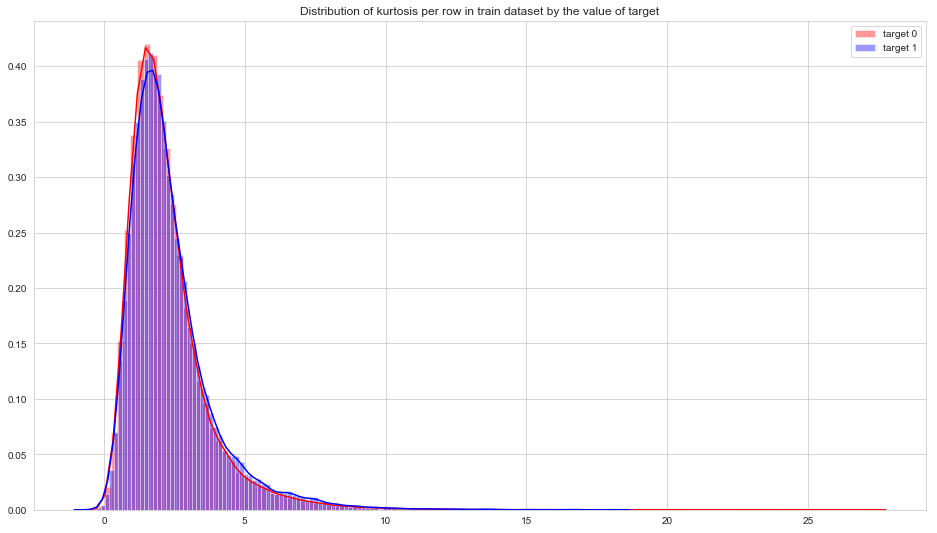

In [49]:
plt.figure(figsize=(16,9))
plt.title("Distribution of kurtosis per row in train dataset by the value of target")
features = train.columns.values[2:202]
target_0 = train[train["target"]==0]
target_1 = train[train["target"]==1]
sns.distplot(train_0[features].kurtosis(axis=1), color='r', bins=120, label='target 0')
sns.distplot(train_1[features].kurtosis(axis=1), color='b',bins=120, label='target 1')
plt.legend(loc="upper right")
# 考察：行ごとの尖度はtarget別で見て大きな差はなし

## 学習データでの列ごとの尖度の分布をtargetで分けて確認

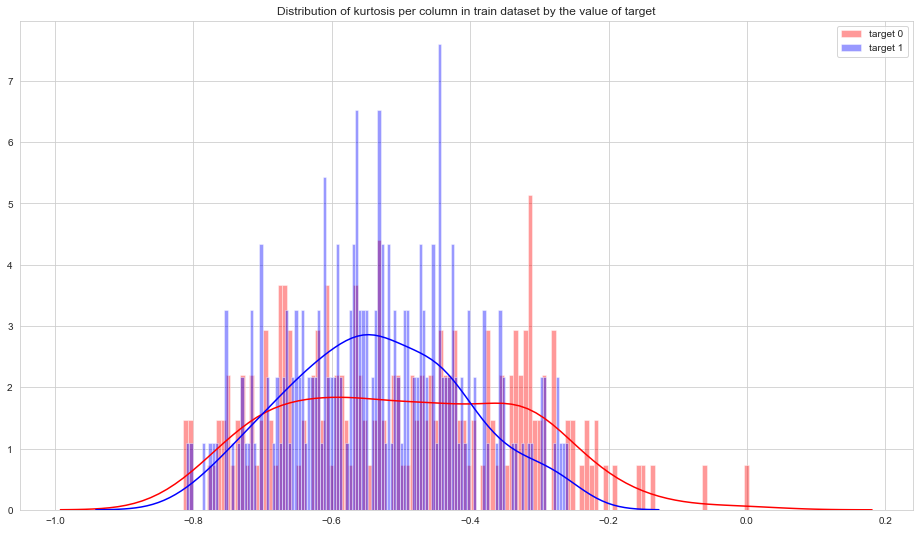

In [48]:
plt.figure(figsize=(16,9))
plt.title("Distribution of kurtosis per column in train dataset by the value of target")
features = train.columns.values[2:202]
target_0 = train[train["target"]==0]
target_1 = train[train["target"]==1]
sns.distplot(train_0[features].kurtosis(axis=0), color='r', bins=120, label='target 0')
sns.distplot(train_1[features].kurtosis(axis=0), color='b',bins=120, label='target 1')
plt.legend(loc="upper right")
# 考察: target1において尖度-0.8から-0.4の値をとる確率がtarget0よりも高くなっている

# targetの分布確認

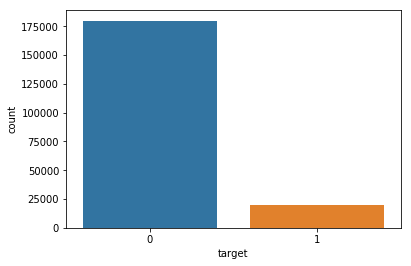

In [61]:
sns.countplot(train["target"]) # 0が圧倒的に多い　→　０と予測すれば大半が正解となってしまう状況

In [60]:
train[train["target"]==1].shape

(20098, 208)

# 密度プロット

<Figure size 432x288 with 0 Axes>

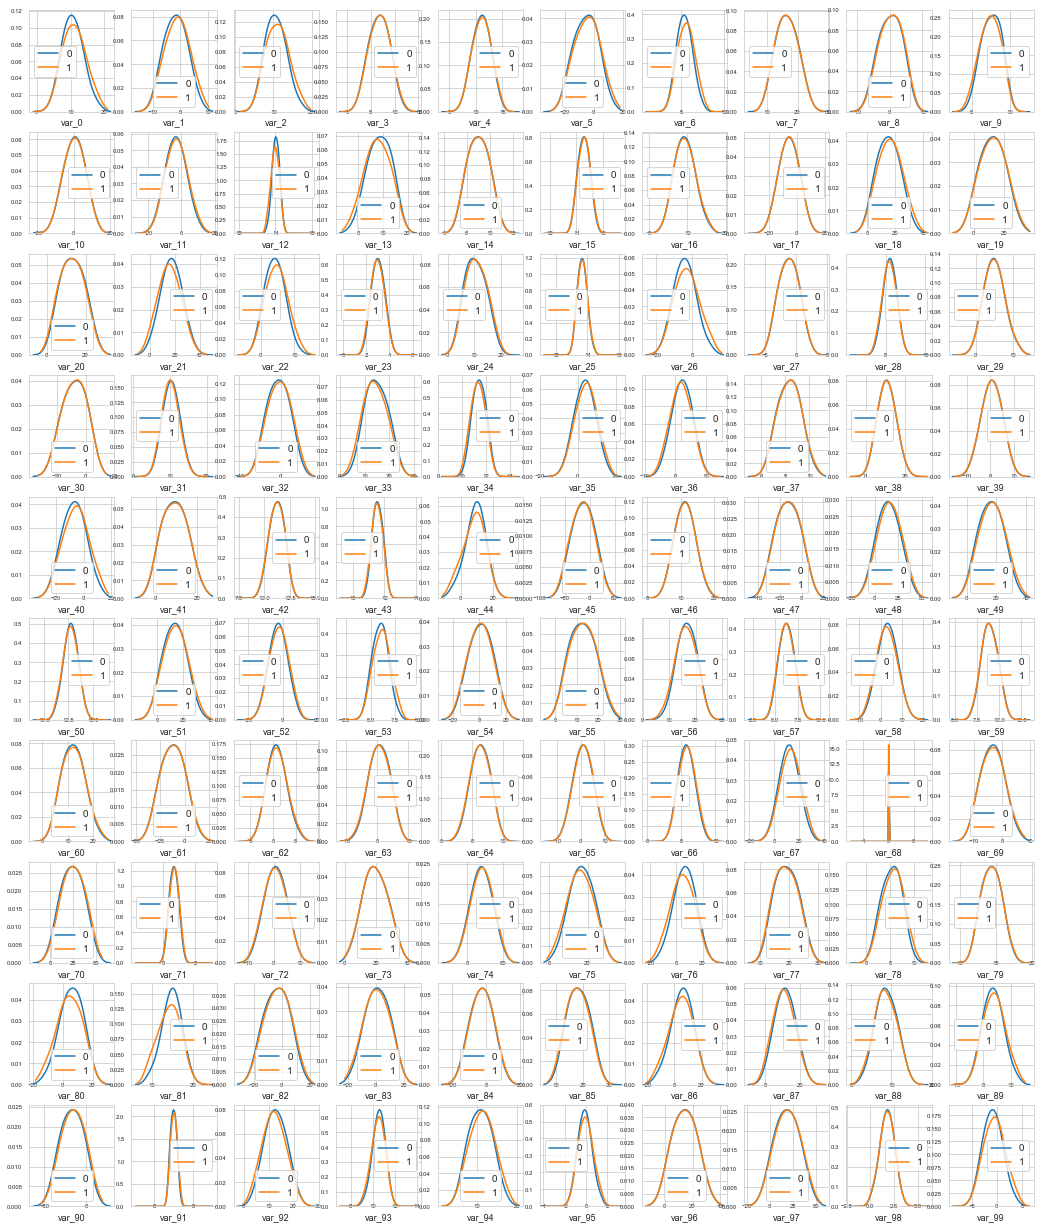

In [32]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

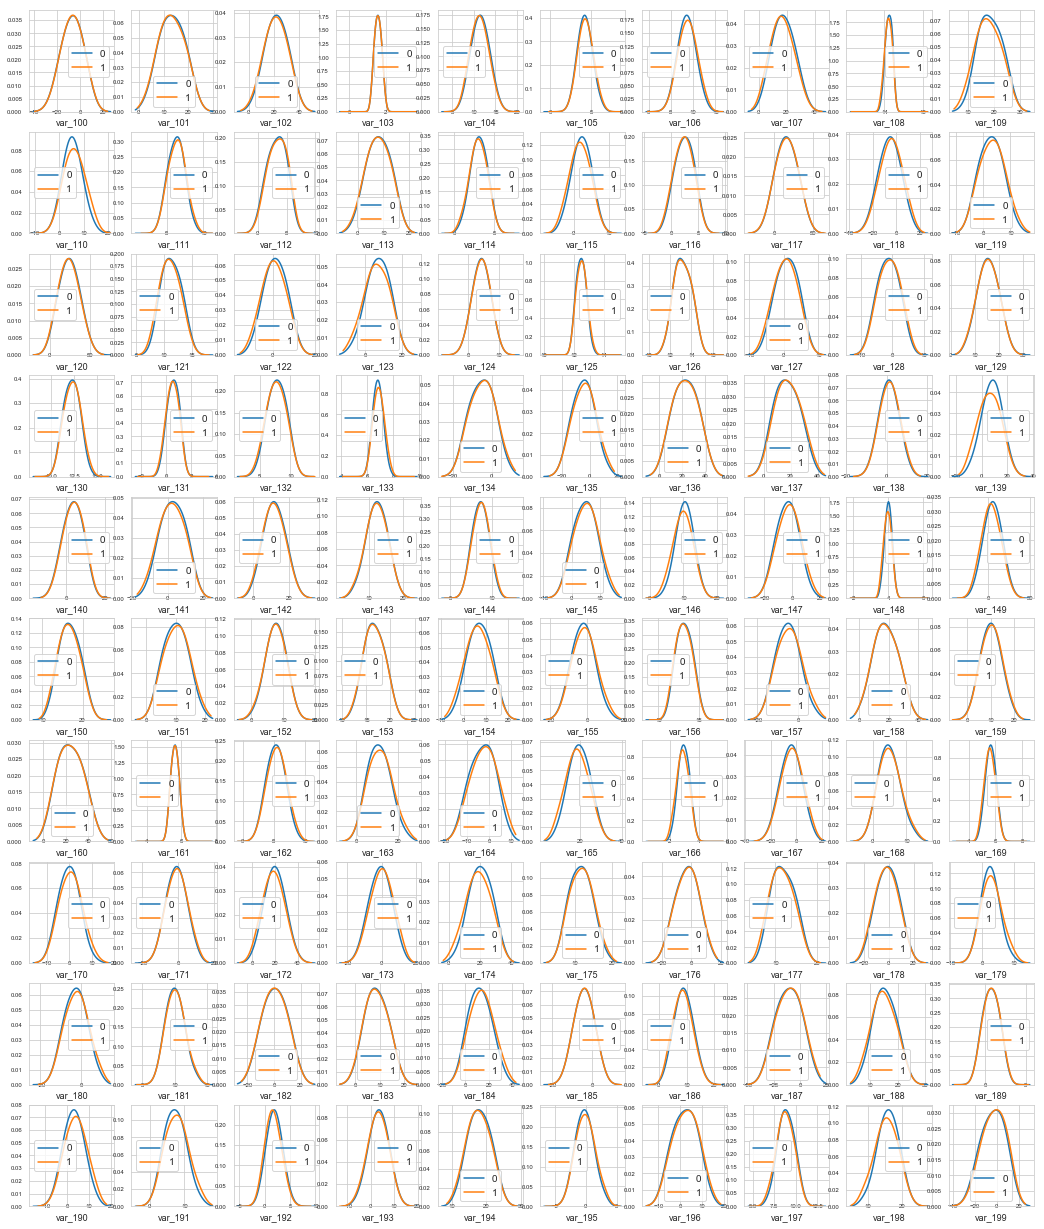

In [33]:
features = train.columns.values[102:]
plot_feature_distribution(t0, t1, '0', '1', features)

# correlation

In [34]:
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

,level_0,level_1,0
0,var_109,var_126,1.313947e-07
1,var_126,var_109,1.313947e-07
2,var_177,var_100,3.116544e-07
3,var_100,var_177,3.116544e-07
4,var_150,var_116,6.628008e-07
5,var_116,var_150,6.628008e-07
6,var_173,var_176,1.318335e-06
7,var_176,var_173,1.318335e-06
8,var_109,var_157,2.494615e-06
9,var_157,var_109,2.494615e-06


In [35]:
correlations.tail(10) # 相関は低いので、相関による問題は気にしなくてもよいと考えられる。

,level_0,level_1,0
9890,var_193,var_172,0.008163
9891,var_172,var_193,0.008163
9892,var_162,var_127,0.008555
9893,var_127,var_162,0.008555
9894,var_122,var_132,0.008956
9895,var_132,var_122,0.008956
9896,var_146,var_169,0.009071
9897,var_169,var_146,0.009071
9898,var_183,var_189,0.009359
9899,var_189,var_183,0.009359


# 被っている値　duplicate value

In [65]:
# 自分で考えたコード  値が被っている変数が多いことが読み取れる
features = X_train.columns.values
dup = []
for i in range(len(features)):
    dup.append(X_train.shape[0] - len(X_train[features[i]].unique()))

dup = pd.DataFrame(dup, columns=["duplicate_no"])
columns = pd.DataFrame(X_train.columns, columns=["variable"])

dup_data = pd.concat([columns, dup], axis=1)
# dup_data = dup_data.sort_values(by="duplicate_no", ascending = False).reset_index(drop=True)
np.transpose(dup_data.sort_values(by="duplicate_no", ascending = False).reset_index(drop=True).head(15))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
variable,var_68,var_91,var_108,var_103,var_12,var_148,var_161,var_71,var_25,var_43,var_125,var_166,var_169,var_133,var_15
duplicate_no,199549,192038,191475,190624,190439,189392,188929,186473,185147,184812,183941,182098,181758,180764,180190


In [52]:
# kernelのコード　 変数ごとに被っている頻度が最も多い数値を頻度とともに表示している
features = train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

In [53]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


In [59]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


In [ ]:
# 結論：　train, testで分けても大きな差はない。しかしtargetごとに分けると全てのケースで確率分布の差を確認できた。その差により、targetの値が0か1
# になるか別れていると考えられる。変数ごとに見て有意な差を産むものと産まないものがあるはずなので、分布に差が見られる変数だけを抽出して要約統計量を
# 新変数として作成すれば、有効な新変数になると仮定する。
# 値が同じになるケースが多いため、同じ変数が複数存在する場合の対処も確認する必要がある。
# 不均衡データに対する対策も必要

# 重要度確認

In [82]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_std[0:1000], y_train[0:1000])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [83]:
importances = list(rf.feature_importances_)
columns = list(X_train.columns)

importances = pd.DataFrame(rf.feature_importances_, columns=["importances"])
columns = pd.DataFrame(X_train.columns, columns=["variable"])

data = pd.concat([columns, importances], axis=1)
np.transpose(data.sort_values(by="importances", ascending = False).reset_index(drop=True).head(15))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
variable,var_15,var_166,var_128,var_190,var_93,var_123,var_165,var_115,var_2,var_12,var_113,var_1,var_119,var_11,var_152
importances,0.0266967,0.0243643,0.0180235,0.0150403,0.0145362,0.0145104,0.0132814,0.0130705,0.0122258,0.0122218,0.0118616,0.0112322,0.0111009,0.0109113,0.0108953
